In [4]:
import torch  # type: ignore
import pyro  # type: ignore (to install it please use %pip install pyro-ppl )
import pyro.distributions as dist  # type: ignore
from pyro.optim import Adam  # type: ignore
from pyro.infer import SVI, Trace_ELBO  # type: ignore
from pyro.infer import MCMC, NUTS, HMC  # type: ignore
from torch.distributions import constraints  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns  # type: ignore
import scipy  # type: ignore
import numpy as np  # type: ignore
import tqdm  # type: ignore
import pyro.poutine as poutine  # type: ignore



# Practical exercises with VI

1- Start from the example seen the last week in class. Extend it to estimate a posterior distribution for the variance

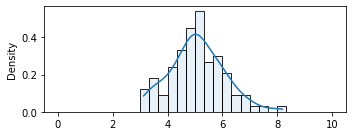

In [5]:
# Example data
true_mean=5
true_std=1
n_samples=100
x = true_mean + true_std * torch.randn(n_samples)# Generate n_samples random noisy data points with mean 5 and standard deviation 1

# Plotting the histogram of the data
plt.figure(figsize=(5, 2))  # Set the figure size
sns.histplot(x, binrange=(0,10), bins=30, kde=True, stat='density', alpha=0.1)  # Plot the histogram with KDE
plt.tight_layout()  # Adjust the layout to fit everything nicely
plt.show()  # Display the plot

In [6]:
def model(x):
    # Introduce a prior on the latent variable theta
    theta_prior = dist.Normal(0.0, 1.0)  # Normal prior distribution over theta
    theta = pyro.sample('theta', theta_prior)  # Sample theta from the prior distribution
    
    sigma_prior = dist.Uniform(0.0, 20.0)  # Normal prior distribution over theta
    sigma = pyro.sample('sigma', sigma_prior)  # Sample theta from the prior distribution

    # Define the likelihood function; 'pyro.plate' is used to indicate a batch of data points
    with pyro.plate('data', len(x)):
        # Sample the observed data from a Normal distribution with mean theta and standard deviation 1
        pyro.sample('obs', dist.Normal(theta, sigma), obs=x)

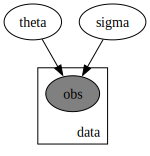

In [7]:
pyro.render_model(model, model_args=(x,))

In [8]:
def guide(x):
    # Here we create a mu and sigma for the Gaussian variational approximation
    tilde_mu = pyro.param('tilde_mu', torch.randn(1))  # Initialize tilde_mu for the variational distribution
    tilde_sigma = pyro.param('tilde_sigma', torch.exp(torch.randn(1)), constraint=dist.constraints.positive)  # Initialize tilde_sigma for the variational distribution, ensuring positivity

    # Sample z from the variational distribution
    pyro.sample('theta', dist.Normal(tilde_mu, tilde_sigma))
    
    sigma_loc = pyro.param('sigma_loc', torch.randn(1))
    pyro.sample("sigma", dist.LogNormal(sigma_loc, torch.tensor(0.05)))

In [9]:
# At this point we can write an optimization routine as we do in PyTorch

def optimisation(x, n_steps=1000, lr=1e-3):
    # Clear any existing parameters in the Pyro parameter store
    pyro.clear_param_store()

    # Define the optimizer and SVI
    adam_params = {'lr': lr}  # Set learning rate for the Adam optimizer
    optimizer = Adam(adam_params)  # Initialize the Adam optimizer for the optimization of the ELBO
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())  # Initialize SVI with the model, guide, optimizer, and loss function as the ELBO
    
    losses = []  # List to store loss values

    # Perform optimization
    for step in range(n_steps):
        loss = svi.step(x)  # Perform a single optimization step
        
        # Record the loss
        losses.append(loss)  # Append the loss to the list
        
        # Print progress every 500 steps
        if (step + 1) % 500 == 0:
            print(f'Step {step + 1} - Loss: {loss:.2f}')

    return pyro.param('tilde_mu').item(), pyro.param('tilde_sigma').item(), pyro.param('sigma_loc').item(), losses

In [10]:
# Perform the optimisation
tilde_mu, tilde_sigma, sigma_loc, losses = optimisation(x, n_steps=5000, lr=1e-2)

Step 500 - Loss: 207.54
Step 1000 - Loss: 168.07
Step 1500 - Loss: 159.74
Step 2000 - Loss: 160.35
Step 2500 - Loss: 160.59
Step 3000 - Loss: 159.69
Step 3500 - Loss: 160.74
Step 4000 - Loss: 158.15
Step 4500 - Loss: 160.32
Step 5000 - Loss: 160.50


In [12]:
print(tilde_mu, tilde_sigma, sigma_loc)

5.039690017700195 0.0990942195057869 -0.0008421680540777743


In [17]:
from scipy.stats import lognorm, norm

posterior_sample_sigma = lognorm.rvs(0.05, loc=sigma_loc, scale=1, size=1000, random_state=None)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f83e0052400>,
 'caps': [<matplotlib.lines.Line2D at 0x7f83e00529e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f83e0052208>],
 'medians': [<matplotlib.lines.Line2D at 0x7f83e0052f98>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f83e005e2b0>],
 'means': []}

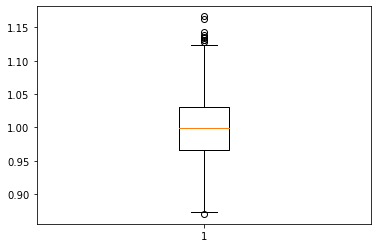

In [18]:
plt.boxplot(posterior_sample_sigma)

In [19]:
posterior_sample_mu = norm.rvs(loc=tilde_mu, scale=tilde_sigma, size=1000, random_state=None)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f83c8879a58>,
 'caps': [<matplotlib.lines.Line2D at 0x7f842a8a6080>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f83c8879860>],
 'medians': [<matplotlib.lines.Line2D at 0x7f842a8a6630>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f842a8a6908>],
 'means': []}

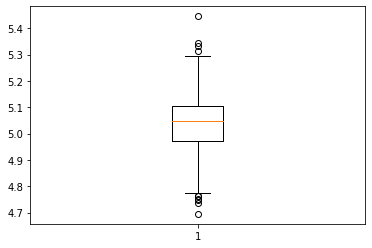

In [20]:
plt.boxplot(posterior_sample_mu)

2- Consider the following linear regression problem. Find the posterior distribution for the regression parameters

In [ ]:
# Generate some synthetic data
N = 100
x = torch.randn(N, 1)
w_true = 2.0
b_true = 1.0
noise_std = 0.5
y = w_true * x + b_true + noise_std * torch.randn(N, 1)
